<a href="https://colab.research.google.com/github/WaleedAhmed565/Ai-lab1/blob/main/stackEnsemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xgboost catboost lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


In [3]:
from google.colab import files
uploaded = files.upload()

# Automatically load the uploaded file
import io
df = pd.read_csv(io.BytesIO(list(uploaded.values())[0]))


Saving pakwheels_pakistan_automobile_dataset.csv to pakwheels_pakistan_automobile_dataset.csv


In [4]:
# Drop unnecessary columns (adjust if needed)
drop_cols = ['post_date', 'price_category', 'price_category.1', 'price_category.2', 'price_category.3']
for col in drop_cols:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

# Remove price outliers (top/bottom 1%)
q1 = df['price'].quantile(0.01)
q99 = df['price'].quantile(0.99)
df = df[(df['price'] >= q1) & (df['price'] <= q99)]

# Create new feature: car age
if 'model' in df.columns:
    df['car_age'] = 2025 - df['model']
    df.drop(columns=['model'], inplace=True)

# Encode categorical features
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])


/tmp/ipython-input-4-1293351546.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['car_age'] = 2025 - df['model']
/tmp/ipython-input-4-1293351546.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['model'], inplace=True)
/tmp/ipython-input-4-1293351546.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [5]:
X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Define base models
base_learners = [
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)),
    ('cat', CatBoostRegressor(verbose=0, iterations=300, learning_rate=0.05))
]

# Final model (meta learner)
meta_model = Ridge(alpha=1.0)

# Stacking Regressor
stacked_model = StackingRegressor(estimators=base_learners, final_estimator=meta_model, n_jobs=-1)

# Train the model
stacked_model.fit(X_train, y_train)


StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(max_depth=10,
                                                     n_estimators=200,
                                                     random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weigh...
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                              ('cat',
                               <catboost.core.CatBoostRegressor object at 0x7d8bf876e550>)],
                  final_estimator=Ridge(), n_jobs=-1)

In [7]:
# Predict and evaluate
y_pred = stacked_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📉 Mean Absolute Error: {mae:,.0f} PKR")
print(f"📈 R² Score: {r2:.4f}")


📉 Mean Absolute Error: 496,715 PKR
📈 R² Score: 0.8458


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


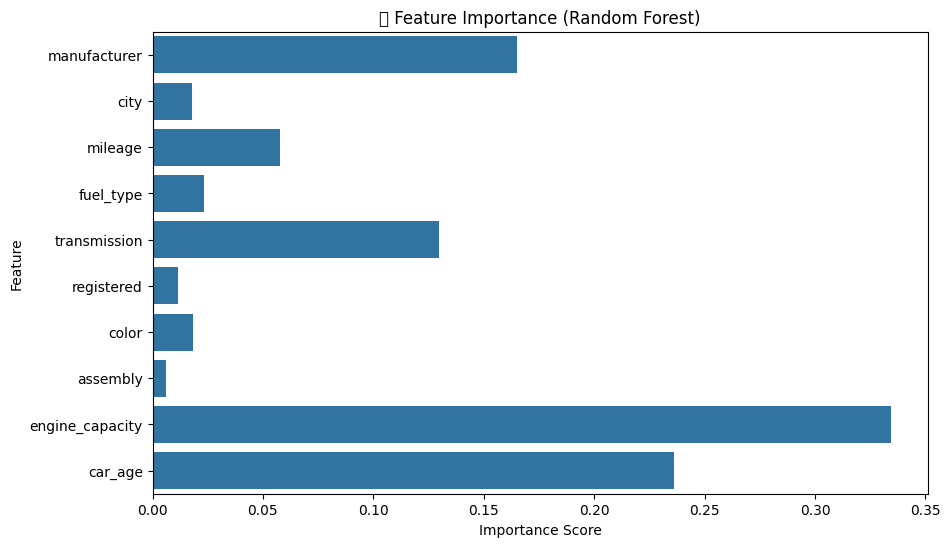

In [9]:
# Step 8: Train Random Forest for Feature Importance (separately)
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Train a simple RF model just for feature importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 9: Show Feature Importance
importances = rf_model.feature_importances_
features = X.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("🔍 Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


In [10]:
# Step 9: Keep only most important features
selected_features = ['manufacturer', 'car_age', 'engine_capacity', 'transmission']
X_selected = X[selected_features]

# Split again using only selected features
X_train_sel, X_test_sel, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Step 10: Train Random Forest on selected features
rf_model_sel = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_sel.fit(X_train_sel, y_train)

# Step 11: Evaluate
from sklearn.metrics import mean_absolute_error, r2_score

y_pred_sel = rf_model_sel.predict(X_test_sel)
mae_sel = mean_absolute_error(y_test, y_pred_sel)
r2_sel = r2_score(y_test, y_pred_sel)

print(f"📉 Mean Absolute Error (selected features): {mae_sel:,.0f} PKR")
print(f"📈 R² Score (selected features): {r2_sel:.4f}")


📉 Mean Absolute Error (selected features): 440,700 PKR
📈 R² Score (selected features): 0.8636


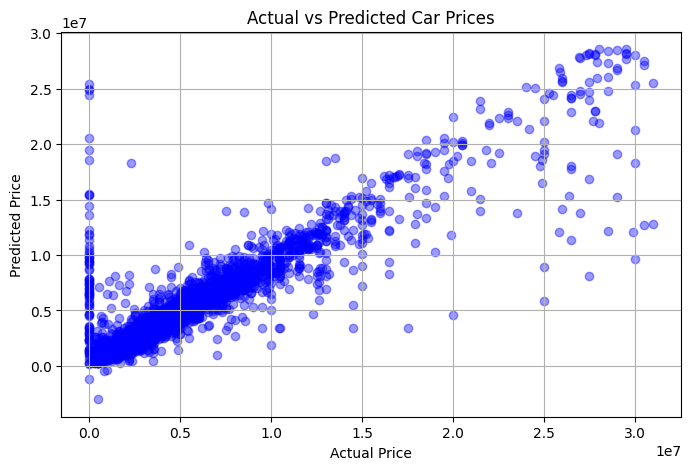

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.4, color='blue')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices")
plt.grid(True)
plt.show()


In [12]:
preds = stacked_model.predict(X_test)
results = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': preds.round(0)
})
results.to_csv("car_price_predictions.csv", index=False)


In [13]:
import joblib

# Save model
joblib.dump(rf_model_sel, 'car_price_model.pkl')

# Download the model file
from google.colab import files
files.download('car_price_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# Example input
new_car = pd.DataFrame({
    'manufacturer': ['Toyota'],
    'car_age': [5],
    'engine_capacity': [1300],
    'transmission': ['Automatic']
})

# Make sure it uses same encoding as training
new_car_encoded = pd.get_dummies(new_car)
new_car_encoded = new_car_encoded.reindex(columns=X_train_sel.columns, fill_value=0)

# Predict
predicted_price = rf_model_sel.predict(new_car_encoded)
print(f"🚗 Predicted Price: {predicted_price[0]:,.0f} PKR")


🚗 Predicted Price: 13,508,063 PKR
